# German Project Analysis: Biowaste and Food Waste

#### Note: the definition of "biowaste" in Germany is slightly different to China, as it includes both food waste and green waste.

In [59]:
library(ggplot2)
library(tidyverse)
library(GGally)
library(VIM)
library(reshape2)
library(gridExtra)
library(missForest)
library(rpart)
library(randomForest)
library(caret)
library(ranger)
library(rpart.plot)
library(gbm)
library(MASS)
library(Benchmarking)

## 1. Data preparation, imputation, and vizualization

In [79]:
# Read in data
df <- read.csv("GermanClean.csv", na.strings="")

In [80]:
# Change certain variable types to factors
df$CodigestedWastes <- as.factor(df$CodigestedWastes)
df$Technology <- as.factor(df$Technology)
df$Temp <- as.factor(df$Temp)
df$DigStages <- as.factor(df$DigStages)
df$Dewatering <- as.factor(df$Dewatering)
df$SFP <- as.factor(df$SFP)


 Variables sorted by number of missings: 
         Variable      Count
 ActualThroughput 0.19469027
              SFP 0.13274336
 CodigestedWastes 0.08849558
        DigStages 0.07964602
   DigestCapacity 0.03539823
             Temp 0.01769912
       Technology 0.00000000
       Dewatering 0.00000000


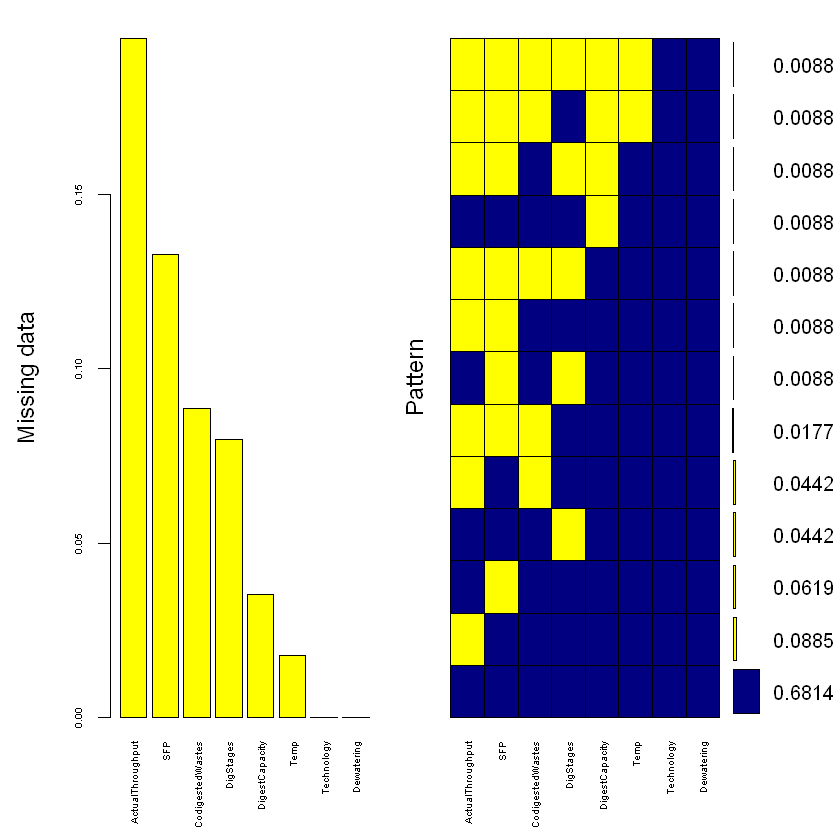

In [81]:
# Test for missing values and visualize  
missVals_plot <- aggr(df, col=c('navyblue','yellow'),
                    numbers=TRUE, sortVars=TRUE,
                    labels=names(df), cex.axis=.5,
                    gap=3, ylab=c("Missing data","Pattern"))

In [83]:
# Imputation of missing values with random forest
df_rfImp <- missForest(df)
df2 <- df_rfImp$ximp

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!


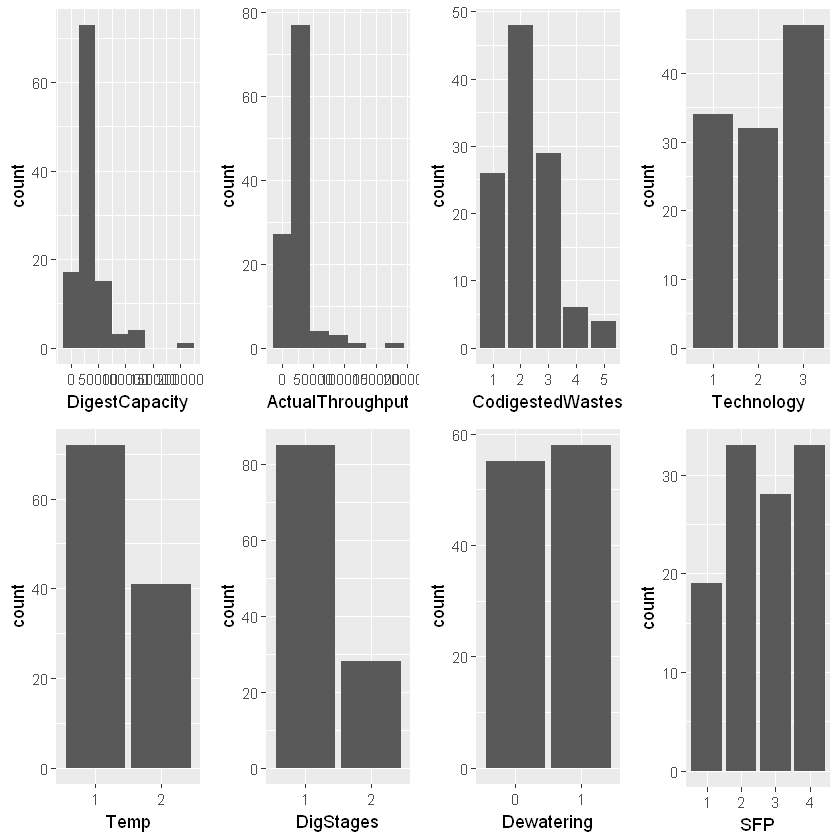

In [86]:
# Visualize the distributions of our variables
h1 <- ggplot(data = df2, aes(x = DigestCapacity)) + geom_histogram(binwidth=30000)
h2 <- ggplot(data = df2, aes(x = ActualThroughput)) + geom_histogram(binwidth=30000)
h3 <- ggplot(data = df2, aes(x = CodigestedWastes)) + geom_bar()
h4 <- ggplot(data = df2, aes(x = Technology)) + geom_bar()
h5 <- ggplot(data = df2, aes(x = Temp)) + geom_bar()
h6 <- ggplot(data = df2, aes(x = DigStages)) + geom_bar()
h7 <- ggplot(data = df2, aes(x = Dewatering)) + geom_bar()
h8 <- ggplot(data = df2, aes(x = SFP)) + geom_bar()

# Place the plot objects into a grid
grid.arrange(h1,h2,h3,h4,h5,h6,h7,h8,ncol=4)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


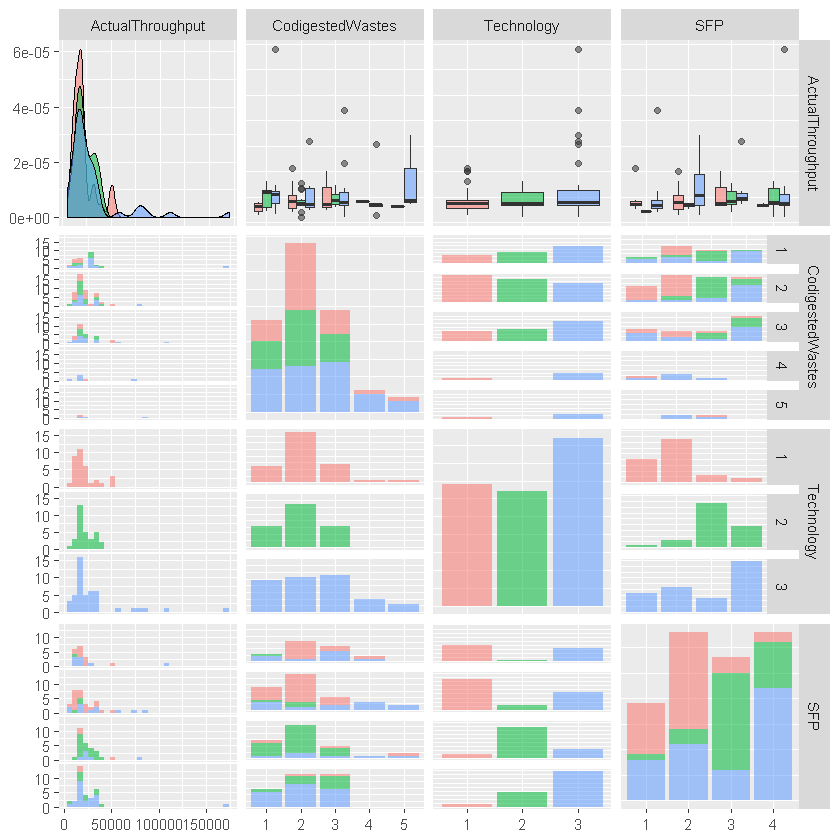

In [94]:
# Pairplot of selected variables:
ggpairs(df2[c(2,3,4,8)], aes(colour = Technology, alpha = 0.4))

## 2. Machine learning

#### In this section, we attempt to build a model that can accurately predict the specific fermenter productivity of the German biogas plants. In additio, we try to gauge which features are most important in predicting the SFP values. 

#### Since the SPF values are factors (1, 2, 3, 4, with 4 being the highest output), this is a classification problem. We will use a random forest model and a gradient boosting machine model.

In [97]:
# Set caret theme
trellis.par.set(caretTheme())

In [101]:
# We will use repeated cross-validation
fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           repeats = 10)

### Random Forest model

In [102]:
# We first train a random forest model
set.seed(0)
rf_mod <- train(SFP ~ ., data = df2, 
                 method = "rf", 
                 trControl = fitControl,
                 tuneLength = 8)

In [110]:
# Model performance summary
rf_mod

Random Forest 

113 samples
  7 predictor
  4 classes: '1', '2', '3', '4' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 100, 101, 103, 101, 102, 101, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.4959988  0.3057642
   3    0.4688531  0.2747966
   4    0.4590280  0.2627263
   5    0.4571608  0.2602869
   7    0.4399790  0.2377751
   8    0.4336748  0.2295236
   9    0.4352622  0.2305908
  11    0.4340839  0.2296667

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

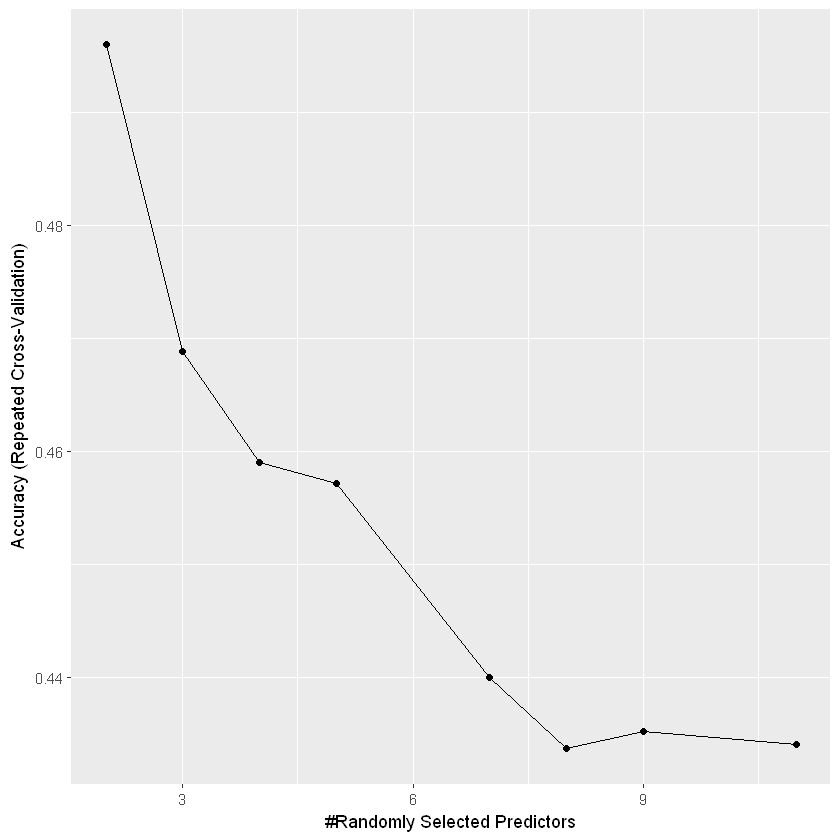

In [107]:
# plot(rf_mod, metric="Accuracy")
ggplot(rf_mod)

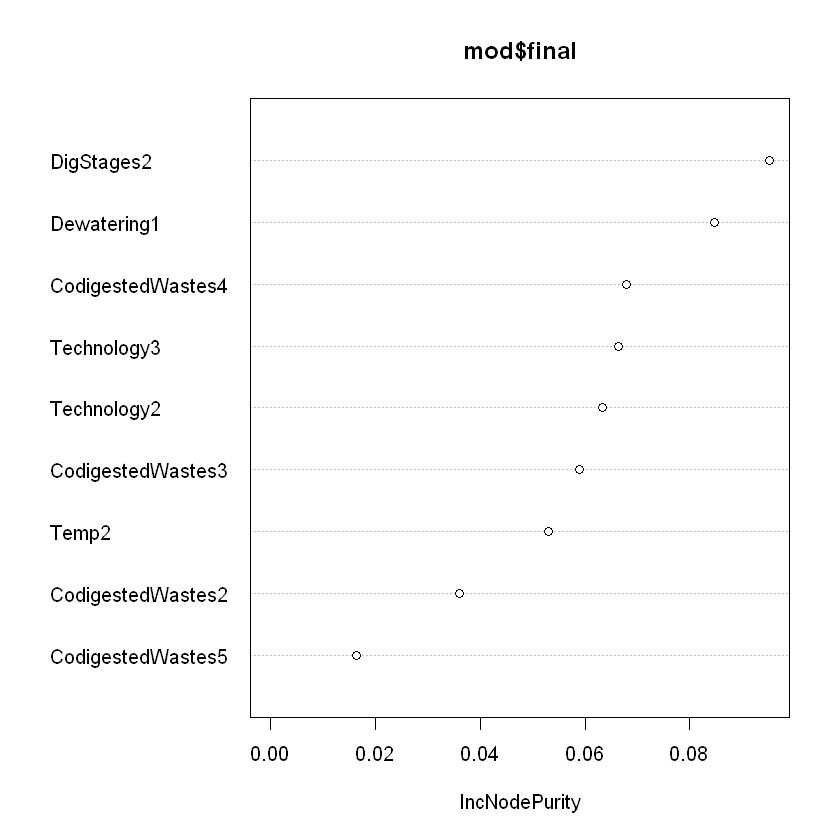

In [111]:
# Variable importance plot
varImpPlot(mod$final)

### Decision Tree model

In [115]:
# Next, we train a recursive partitioning model for more interpretable output
set.seed(0)
mod1 <- train(SFP ~ ., data = df2, 
                 method = "rpart", 
                 trControl = fitControl,
                 tuneLength = 8)

In [116]:
mod1

CART 

113 samples
  7 predictor
  4 classes: '1', '2', '3', '4' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 100, 101, 103, 101, 102, 101, ... 
Resampling results across tuning parameters:

  cp          Accuracy   Kappa     
  0.00000000  0.5143100  0.34008710
  0.02857143  0.5153135  0.33046631
  0.05714286  0.5179266  0.32954891
  0.08571429  0.5307529  0.34753916
  0.11428571  0.4943601  0.29926201
  0.14285714  0.4263741  0.20524020
  0.17142857  0.4233590  0.19981605
  0.20000000  0.3029161  0.04010909

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.08571429.

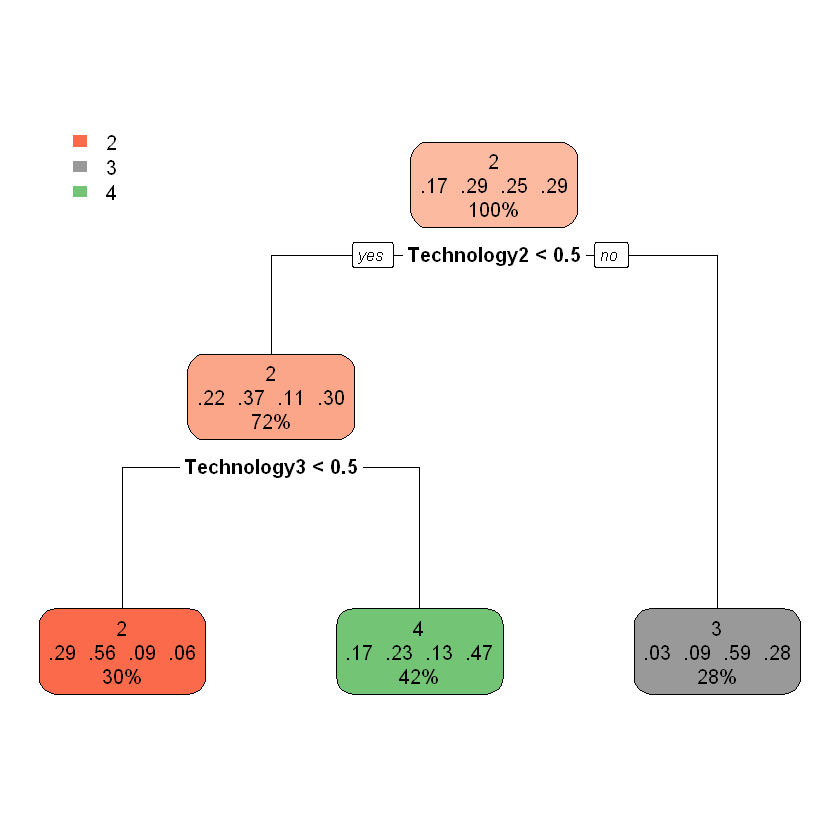

In [117]:
rpart.plot(mod1$finalModel)

### Stochastic gradient boosting model

In [118]:
# Lastly, we train a gbm model
set.seed(0)
mod2 <- train(SFP ~ ., data = df2, 
                 method = "gbm", 
                 trControl = fitControl,
                 tuneLength = 8)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3863             nan     0.1000    0.0827
     2        1.3298             nan     0.1000    0.0470
     3        1.2829             nan     0.1000   -0.0048
     4        1.2682             nan     0.1000    0.0033
     5        1.2497             nan     0.1000    0.0320
     6        1.2114             nan     0.1000   -0.0048
     7        1.1880             nan     0.1000   -0.0054
     8        1.1696             nan     0.1000   -0.0177
     9        1.1522             nan     0.1000   -0.0049
    10        1.1338             nan     0.1000   -0.0205
    20        1.0298             nan     0.1000   -0.0311
    40        0.9216             nan     0.1000   -0.0273
    60        0.8488             nan     0.1000   -0.0212
    80        0.7884             nan     0.1000   -0.0388
   100        0.7501             nan     0.1000   -0.0355
   120        0.7078             nan     0.1000   -0.0236
   140        

In [119]:
# Model performance summary
mod2

Stochastic Gradient Boosting 

113 samples
  7 predictor
  4 classes: '1', '2', '3', '4' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 100, 101, 103, 101, 102, 101, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  Accuracy   Kappa    
  1                   50      0.4931002  0.3044084
  1                  100      0.4938695  0.3074883
  1                  150      0.4905781  0.3031553
  1                  200      0.4939720  0.3076509
  1                  250      0.4888403  0.2998262
  1                  300      0.4877867  0.2992922
  1                  350      0.4866620  0.3000761
  1                  400      0.4806282  0.2916834
  2                   50      0.5041655  0.3201787
  2                  100      0.5008287  0.3183889
  2                  150      0.4926702  0.3103942
  2                  200      0.4977191  0.3169828
  2                  250      0.5002413  0.3213418
  2          

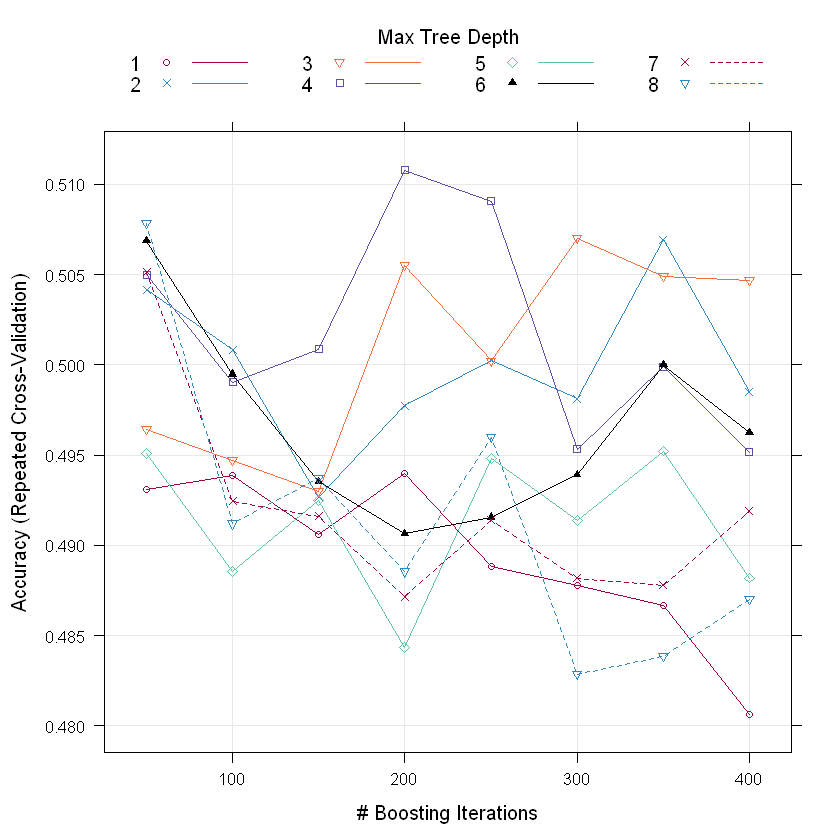

In [120]:
# Model training visualization
plot(mod2)

## 3. DEA on German projects

In [121]:
# Create a new dataframe for the DEA and assign x and y variable values
df3 <- df2
df3$SFP <- as.numeric(df3$SFP)
x <- matrix(df3$ActualThroughput)
y <- matrix(df3$SFP)

In [122]:
# Run the DEA model (one input, one output, input-oriented)
e_vrs <- dea(x,y, RTS="vrs", ORIENTATION = "in")

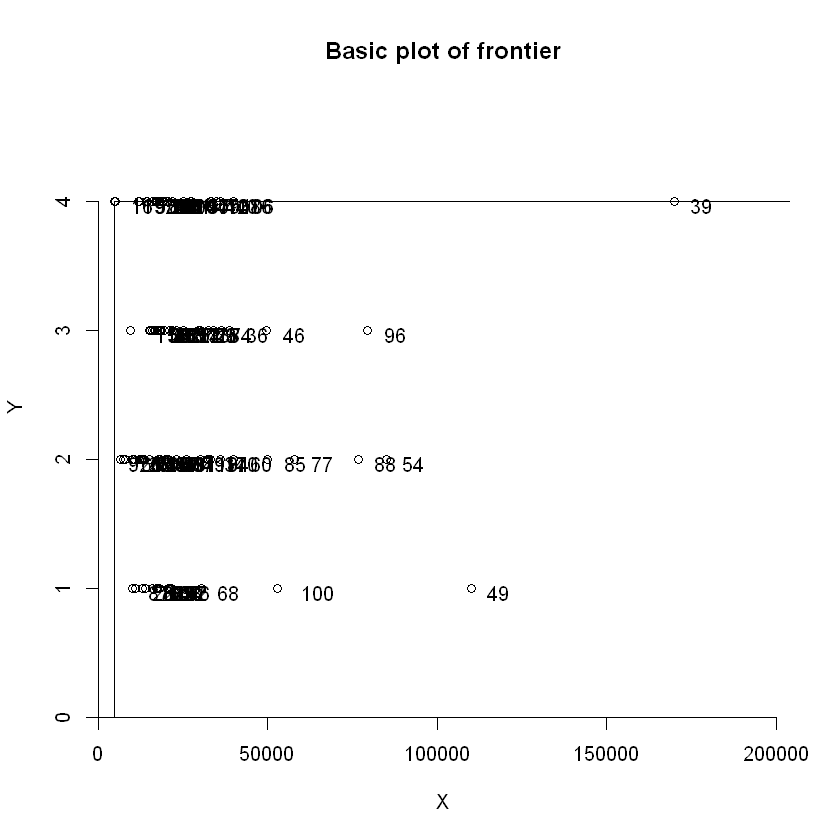

In [123]:
# Plot of different technologies with a title
dea.plot(x,y, txt=1:dim(x)[1],main="Basic plot of frontier")
dea.plot(x,y,RTS="vrs",add=TRUE,lty="dashed")

In [ ]:
# e_vrs$lambda

# to do:
# Graphs of the outputs, peers, lambdas
# RF/DT/reg correlation of efficiency scores with other features

#### Second stage of DEA: determinants of efficiency 

In [124]:
#First we build a new df for regressing features on efficiency values
df4 <- df3
eff <- e_vrs$eff
df4$eff <- eff

In [125]:
names(df4)

[1] "DigestCapacity"   "ActualThroughput" "CodigestedWastes" "Technology"      
[5] "Temp"             "DigStages"        "Dewatering"       "SFP"             
[9] "eff"

In [130]:
# Efficiency model with cv and rf model
set.seed(0)
eff_mod_rf <- train(eff ~ ., data = df4[c(3:7,9)], 
                 method = "rf", 
                 trControl = fitControl,
                 tuneLength = 8)

In [131]:
# Model performance summary
eff_mod_rf

Random Forest 

113 samples
  5 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 102, 101, 101, 103, 101, 102, ... 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared    MAE      
  2     0.1532111  0.07320060  0.1105429
  3     0.1575515  0.06809981  0.1146656
  4     0.1608031  0.06615855  0.1174568
  5     0.1635587  0.06593418  0.1195566
  6     0.1652247  0.06605407  0.1209062
  7     0.1667979  0.06464441  0.1222516
  8     0.1683576  0.06571740  0.1232114
  9     0.1690339  0.06520001  0.1237475

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 2.

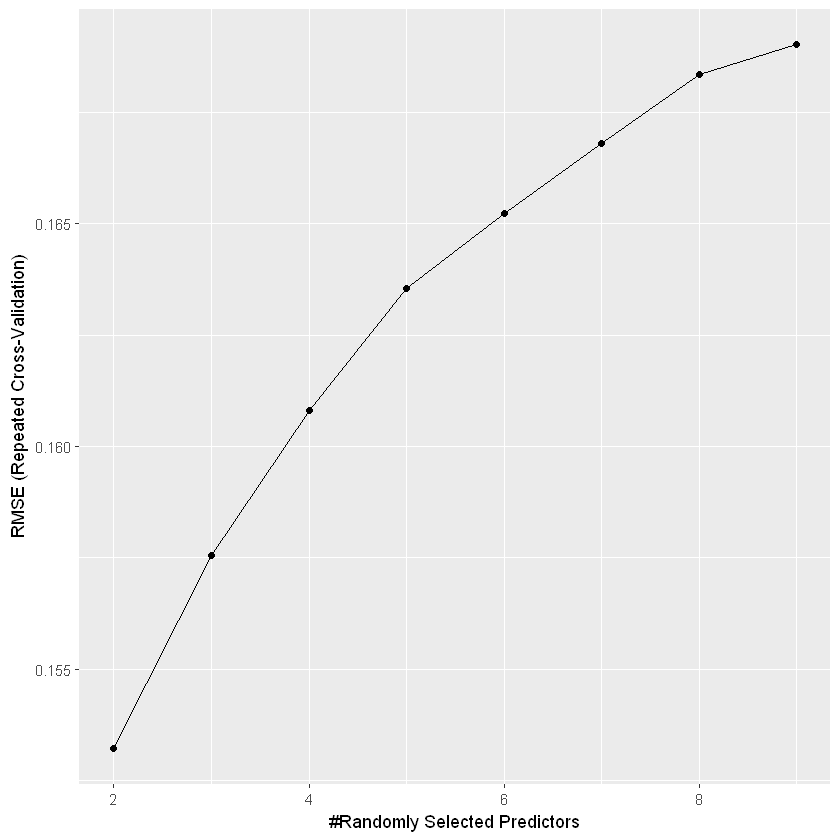

In [132]:
# Model training visualization
ggplot(eff_mod_rf)

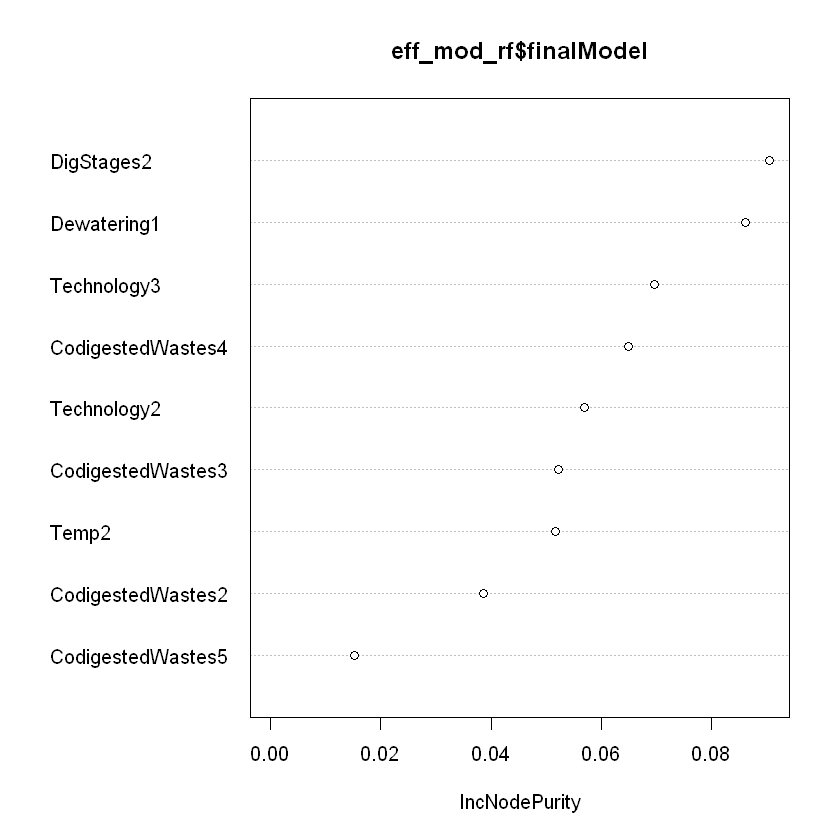

In [133]:
# Variable importance plot
varImpPlot(eff_mod_rf$finalModel)